<a href="https://colab.research.google.com/github/JestinG20/ldct-image-denoising/blob/main/ldct-image-denosing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Subject ID:
- C002
- C004
- C012
- C016
- C021
- C027
- C111
- L049
- L056
- L057
- L058
- L064
- L071
- L072
- L075
- L077
- L107
- L110
- L114
- L125
- L131
- L170
- N139
- N140
- N300
'''

In [ ]:
!pip install pydicom
import pydicom as dicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from numpy.random import randint
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
directories_full = './drive/MyDrive/LDCT Image Denoising/FULL'
directories_low = './drive/MyDrive/LDCT Image Denoising/LOW'

In [ ]:
def load_data_from_dirs(dirs):
    files = []
    entries = os.listdir(dirs)
    sorted_entries = sorted(entries)
    for f in sorted_entries:
        if f.endswith('dcm'):
            print(f)
            file_name = os.path.join(dirs,f)
            ds = dicom.dcmread(file_name)
            image = ds.pixel_array
            files.append(image)
    return files

In [ ]:
fr_data = load_data_from_dirs(directories_full)
lr_data = load_data_from_dirs(directories_low)

Streaming output truncated to the last 5000 lines.
817.dcm
818.dcm
819.dcm
82.dcm
820.dcm
821.dcm
822.dcm
823.dcm
824.dcm
825.dcm
826.dcm
827.dcm
828.dcm
829.dcm
83.dcm
830.dcm
831.dcm
832.dcm
833.dcm
834.dcm
835.dcm
836.dcm
837.dcm
838.dcm
839.dcm
84.dcm
840.dcm
841.dcm
842.dcm
843.dcm
844.dcm
845.dcm
846.dcm
847.dcm
848.dcm
849.dcm
85.dcm
850.dcm
851.dcm
852.dcm
853.dcm
854.dcm
855.dcm
856.dcm
857.dcm
858.dcm
859.dcm
86.dcm
860.dcm
861.dcm
862.dcm
863.dcm
864.dcm
865.dcm
866.dcm
867.dcm
868.dcm
869.dcm
87.dcm
870.dcm
871.dcm
872.dcm
873.dcm
874.dcm
875.dcm
876.dcm
877.dcm
878.dcm
879.dcm
88.dcm
880.dcm
881.dcm
882.dcm
883.dcm
884.dcm
885.dcm
886.dcm
887.dcm
888.dcm
889.dcm
89.dcm
890.dcm
891.dcm
892.dcm
893.dcm
894.dcm
895.dcm
896.dcm
897.dcm
898.dcm
899.dcm
9.dcm
90.dcm
900.dcm
901.dcm
902.dcm
903.dcm
904.dcm
905.dcm
906.dcm
907.dcm
908.dcm
909.dcm
91.dcm
910.dcm
911.dcm
912.dcm
913.dcm
914.dcm
915.dcm
916.dcm
917.dcm
918.dcm
919.dcm
92.dcm
920.dcm
921.dcm
922.dcm
923.dcm
924.dcm
92

In [ ]:
lr_data = np.array(lr_data)
fr_data = np.array(fr_data)

In [ ]:
lr_train = lr_data[:4200]
fr_train = fr_data[:4200]
lr_test = lr_data[4200:]
fr_test = fr_data[4200:]

In [ ]:
print("LR train Number of images: ", lr_train.shape[0])
print("LR train Height: ", lr_train.shape[1])
print("LR train Width: ", lr_train.shape[2])
print("FR train Number of images: ", fr_train.shape[0])
print("FR train Height: ", fr_train.shape[1])
print("FR train Width: ", fr_train.shape[2])
print("LR test Number of images: ", lr_test.shape[0])
print("LR test Height: ", lr_test.shape[1])
print("LR test Width: ", lr_test.shape[2])
print("FR test Number of images: ", fr_test.shape[0])
print("FR test Height: ", fr_test.shape[1])
print("FR test Width: ", fr_test.shape[2])
lr_train = lr_train.reshape((lr_train.shape[0], lr_train.shape[1],lr_train.shape[2], 1))
fr_train = fr_train.reshape((fr_train.shape[0], fr_train.shape[1],fr_train.shape[2], 1))
lr_test = lr_test.reshape((lr_test.shape[0], lr_test.shape[1],lr_test.shape[2], 1))
fr_test = fr_test.reshape((fr_test.shape[0], fr_test.shape[1],fr_test.shape[2], 1))

LR train Number of images:  4200
LR train Height:  512
LR train Width:  512
FR train Number of images:  4200
FR train Height:  512
FR train Width:  512
LR test Number of images:  598
LR test Height:  512
LR test Width:  512
FR test Number of images:  598
FR test Height:  512
FR test Width:  512


In [ ]:
np.save('./drive/MyDrive/LDCT Image Denoising/fr_train.npy', fr_train)
np.save('./drive/MyDrive/LDCT Image Denoising/lr_train.npy', lr_train)
np.save('./drive/MyDrive/LDCT Image Denoising/fr_test.npy', fr_test)
np.save('./drive/MyDrive/LDCT Image Denoising/lr_test.npy', lr_test)

In [ ]:
lr_train = np.load('./drive/MyDrive/LDCT Image Denoising/lr_train.npy')
fr_train = np.load('./drive/MyDrive/LDCT Image Denoising/fr_train.npy')
lr_test = np.load('./drive/MyDrive/LDCT Image Denoising/lr_test.npy')
fr_test = np.load('./drive/MyDrive/LDCT Image Denoising/fr_test.npy')

In [ ]:
def crop_image(example):
    img = example['hr']
    img1 = example['lr']
    hr_patch = tf.image.central_crop(img,0.5)
    lr_patch = tf.image.central_crop(img1,0.5)
    hr_patch = tf.cast(hr_patch, tf.float32) / (255. / 2.)
    lr_patch = tf.cast(lr_patch, tf.float32) / (255. / 2.)
    return lr_patch, hr_patch

In [ ]:
print(lr_train.shape)
print(fr_train.shape)

(4200, 512, 512, 1)
(4200, 512, 512, 1)


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices({'lr': lr_train,'hr': fr_train})

In [ ]:
train_dataset = train_data.map(crop_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

In [ ]:
train_dataset = train_dataset.batch(16).repeat()

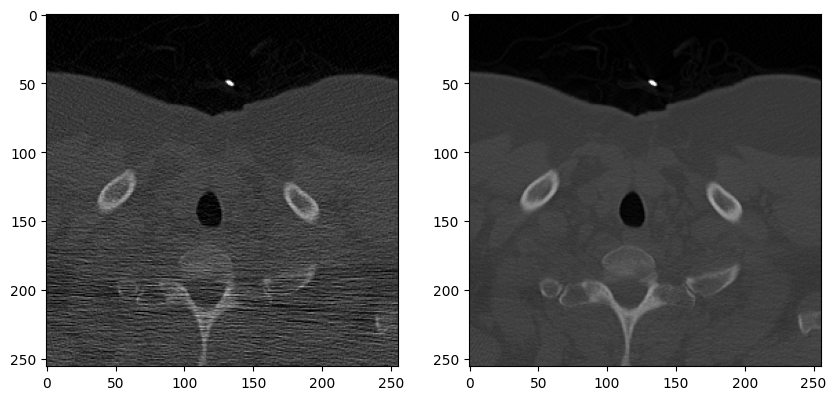

In [ ]:
cropped_img_iter = iter(train_dataset)
val_cropped_img = next(cropped_img_iter)
fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(tf.squeeze(val_cropped_img[0][0]),cmap='gray')
axes[1].imshow(tf.squeeze(val_cropped_img[1][0]),cmap='gray')

In [ ]:
#GENERATOR

inputs = tf.keras.Input(shape=(256, 256, 1)) # Model to 2x the image
x = inputs
x = tf.keras.layers.Conv2D(64, 9, padding='same')(x)
x = tf.keras.layers.PReLU()(x)
c1 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c1, x])
c2 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c2, x])
c3 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c3, x])
c4 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c4, x])
c5 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c5, x])
c6 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c1, x])

x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
#x = tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
x = tf.keras.layers.PReLU()(x)

x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
#x = tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
x = tf.keras.layers.PReLU()(x)

x = tf.keras.layers.Conv2D(1, 9, padding='same')(x)
output = x
model = tf.keras.Model(inputs, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          5,248 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_re_lu (PReLU)           │ (None, 256, 256, 64)   │      4,194,304 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ p_re_lu[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_re_lu_1 (PReLU)         │ (None, 256, 256, 64)   │      4,194,304 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ p_re_lu_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 64)   │              0 │ p_re_lu[0][0],         │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_re_lu_2 (PReLU)         │ (None, 256, 256, 64)   │      4,194,304 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ p_re_lu_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 64)   │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 256, 64)   │              0 │ add[0][0],             │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 59,893,057 (228.47 MB)

 Trainable params: 59,891,649 (228.47 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
#DISCRIMINATOR

inputs_d = tf.keras.Input(shape=(256, 256, 1)) # Discriminator Model
x_d = inputs_d
x_d = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(128, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(256, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(512, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(512, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Flatten()(x_d)
x_d = tf.keras.layers.Dense(1024)(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)
x_d = tf.keras.layers.Dense(1, activation='sigmoid')(x_d)
output_d = x_d
model_d = tf.keras.Model(inputs_d, output_d)
model_d.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,1

 Total params: 38,248,129 (145.91 MB)

 Trainable params: 38,244,417 (145.89 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

class GAN(tf.keras.Model):
  def __init__(self, discriminator, generator):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator

  def compile(self,
              d_optimizer,
              g_optimizer,
              loss_fn,
              recon_loss_fn,
              loss_weights=[1,1,1]):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.recon_loss_fn = recon_loss_fn
    self.loss_weights = loss_weights

  def train_step(self, data):
    input_images, real_images = data
    batch_size = tf.shape(real_images)[0]
    #print(batch_size)
    generated_images = self.generator(input_images)
    combined_images = tf.concat([generated_images, real_images], axis=0)
    labels = tf.concat([tf.ones((batch_size, 1)),
                        -tf.ones((batch_size, 1))], axis=0)
    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    print(tf.shape(combined_images))
    with tf.GradientTape() as tape:
      noise_concat = tf.concat([tf.random.normal(shape=tf.shape(generated_images), mean=0.0, stddev=0.1, dtype=tf.float32),
                                tf.zeros(shape=tf.shape(real_images))], axis=0)
      noisy_image =combined_images + noise_concat
      print(tf.shape(noisy_image))
      predictions = self.discriminator(noisy_image)
      d_loss = self.loss_fn(labels, predictions)
      d_loss = d_loss*self.loss_weights[0]
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    with tf.GradientTape() as tape:
      generated_images = self.generator(input_images)
      predictions = self.discriminator(generated_images)
      g_loss = self.loss_fn(-tf.ones((batch_size, 1)), predictions)
      recon_loss = self.recon_loss_fn(real_images, generated_images)
      loss = g_loss*self.loss_weights[1] + recon_loss*self.loss_weights[2]
    grads = tape.gradient(loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    psnr = tf.image.psnr(generated_images, real_images, max_val=2.0)
    ssim = tf.image.ssim(generated_images, real_images, max_val=2.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
    return { 'd_loss': d_loss, 'g_loss': g_loss, 'recon_loss': recon_loss, 'PSNR':psnr, 'SSIM':ssim }


gan_model = GAN(model_d, model)
gan_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
                  tf.keras.optimizers.Adam(learning_rate=0.0001),
                  discriminator_loss,
                  lambda y, x: tf.reduce_mean(tf.keras.losses.MeanSquaredError()(y, x)),
                  loss_weights=[1,10, 1])

In [ ]:
gan_model.fit(train_dataset, steps_per_epoch=30, epochs=6)

Epoch 1/6
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - PSNR: 11.2128 - SSIM: 0.4680 - d_loss: -0.0242 - g_loss: 1.0000 - recon_loss: 0.3137
Epoch 2/6
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - PSNR: 12.1636 - SSIM: 0.4712 - d_loss: -0.0248 - g_loss: 1.0000 - recon_loss: 0.2574
Epoch 3/6
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - PSNR: 10.9111 - SSIM: 0.3965 - d_loss: -0.0245 - g_loss: 1.0000 - recon_loss: 0.3500
Epoch 4/6
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - PSNR: 20.0268 - SSIM: 0.7157 - d_loss: -0.0247 - g_loss: 1.0000 - recon_loss: 0.0713
Epoch 5/6
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - PSNR: 20.6960 - SSIM: 0.7331 - d_loss: -0.0252 - g_loss: 1.0000 - recon_loss: 0.0633
Epoch 6/6
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - PSNR: 21.3566 - SSIM: 0.7344 - d_loss: -0.0252 - g_loss: 1.0000 - recon_loss: 0.0588


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step


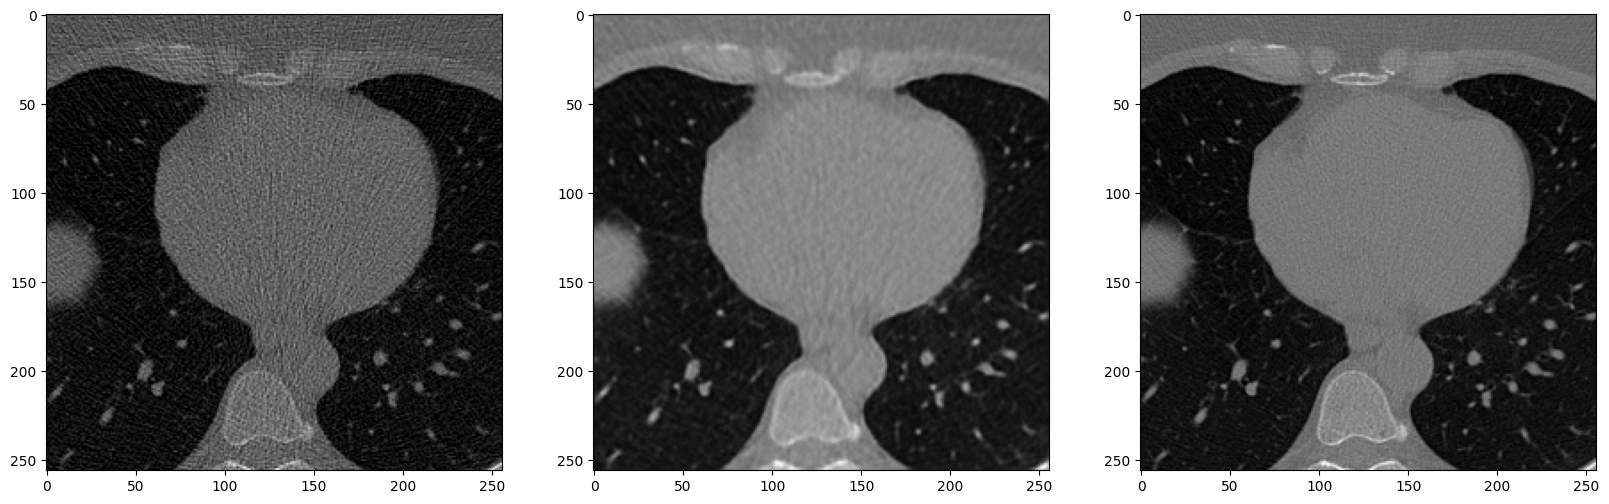

In [ ]:
fakes = model.predict(val_cropped_img[0])
fig, axes = plt.subplots(1,3, figsize=(20,20))
ds = np.squeeze(val_cropped_img[0][1].numpy())
us = np.squeeze(fakes[1])
ori = np.squeeze(val_cropped_img[1][1])
ds = (ds - ds.min()) / (ds.max() - ds.min())
us = (us - us.min()) / (us.max() - us.min())
ori = (ori - ori.min()) / (ori.max() - ori.min())
axes[0].imshow(ds,cmap='gray')
axes[1].imshow(us,cmap='gray')
axes[2].imshow(ori,cmap='gray')

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices({'lr': lr_test,'hr': fr_test})
test_data = test_data.map(crop_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
test_data = test_data.batch(16)

In [ ]:
PSNR = []
SSIM = []
count_num = 0
for img1, img2 in test_data:
  # psnr_test = tf.image.psnr(img1,img2,max_val=2.0)
  # ssim_test = tf.image.ssim(img1,img2,max_val=2.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
  # PSNR.append(psnr_test)
  # SSIM.append(ssim_test)
  # count_num += 1
  psnr_test = tf.image.psnr(img1,img2,max_val=2.0)
  ssim_test = tf.image.ssim(img1,img2,max_val=2.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
  # Append the individual values instead of the whole tensor
  PSNR.extend(psnr_test.numpy())
  SSIM.extend(ssim_test.numpy())
  count_num += 1
PSNR = tf.convert_to_tensor(PSNR)
PSNR_ave = tf.math.reduce_mean(PSNR[PSNR<1000])
psnr_array = PSNR_ave.numpy()
print(psnr_array[psnr_array < 1000])
SSIM = tf.convert_to_tensor(SSIM)
SSIM_ave = tf.math.reduce_mean(SSIM)
print(SSIM_ave.numpy())

[3.648309]
0.29953912


In [ ]:
PSNR = []
SSIM = []

for img1, img2 in test_data:
  predicted_img = model.predict(img1)
  psnr_test = tf.image.psnr(predicted_img,img2,max_val=2.0)
  ssim_test = tf.image.ssim(predicted_img,img2,max_val=2.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
  # PSNR.append(psnr_test)
  # SSIM.append(ssim_test)
  PSNR.extend(psnr_test.numpy())
  SSIM.extend(ssim_test.numpy())

PSNR = tf.convert_to_tensor(PSNR)
PSNR_ave = tf.math.reduce_mean(PSNR)
print(PSNR_ave.numpy())
SSIM = tf.convert_to_tensor(SSIM)
SSIM_ave = tf.math.reduce_mean(SSIM)
print(SSIM_ave.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


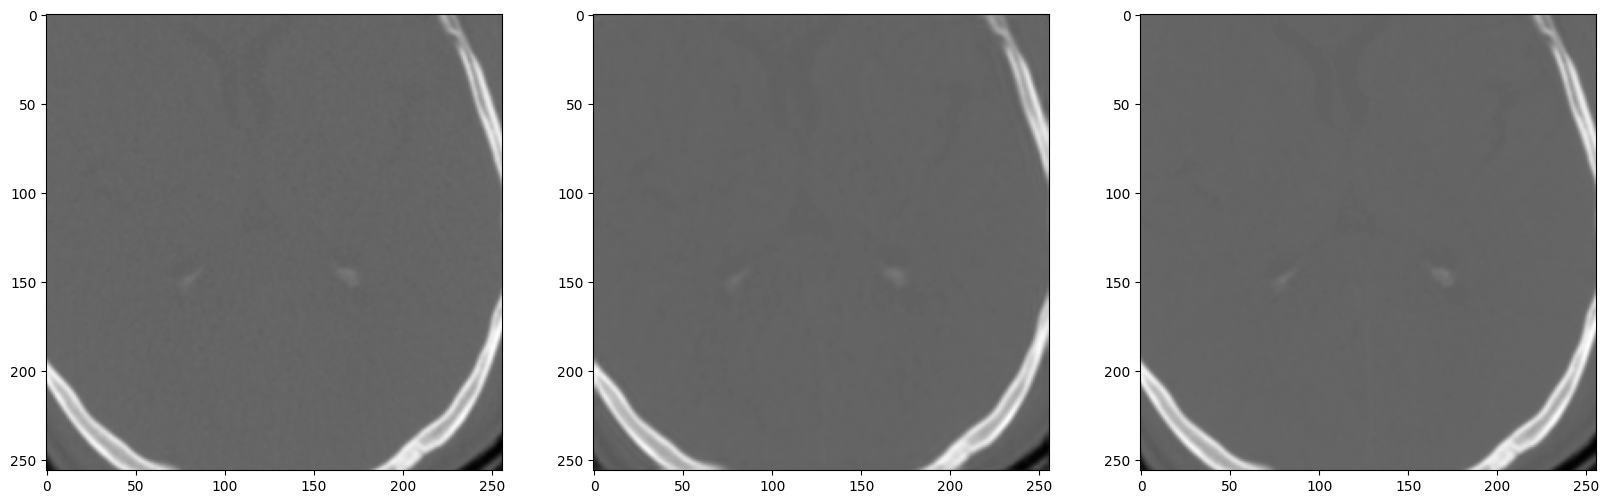

In [ ]:
cropped_img_iter_test = iter(test_data)
val_cropped_img_test  = next(cropped_img_iter_test )
fakes_test  = model.predict(val_cropped_img_test[0])
fig, axes = plt.subplots(1,3, figsize=(20,20))
ds = np.squeeze(val_cropped_img_test[0][2].numpy())
us = np.squeeze(fakes_test[2])
ori = np.squeeze(val_cropped_img_test[1][2])
ds = (ds - ds.min()) / (ds.max() - ds.min())
us = (us - us.min()) / (us.max() - us.min())
ori = (ori - ori.min()) / (ori.max() - ori.min())
axes[0].imshow(ds,cmap='gray')
axes[1].imshow(us,cmap='gray')
axes[2].imshow(ori,cmap='gray')
#plt.savefig('100epoch_wgan_0.0001wei.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


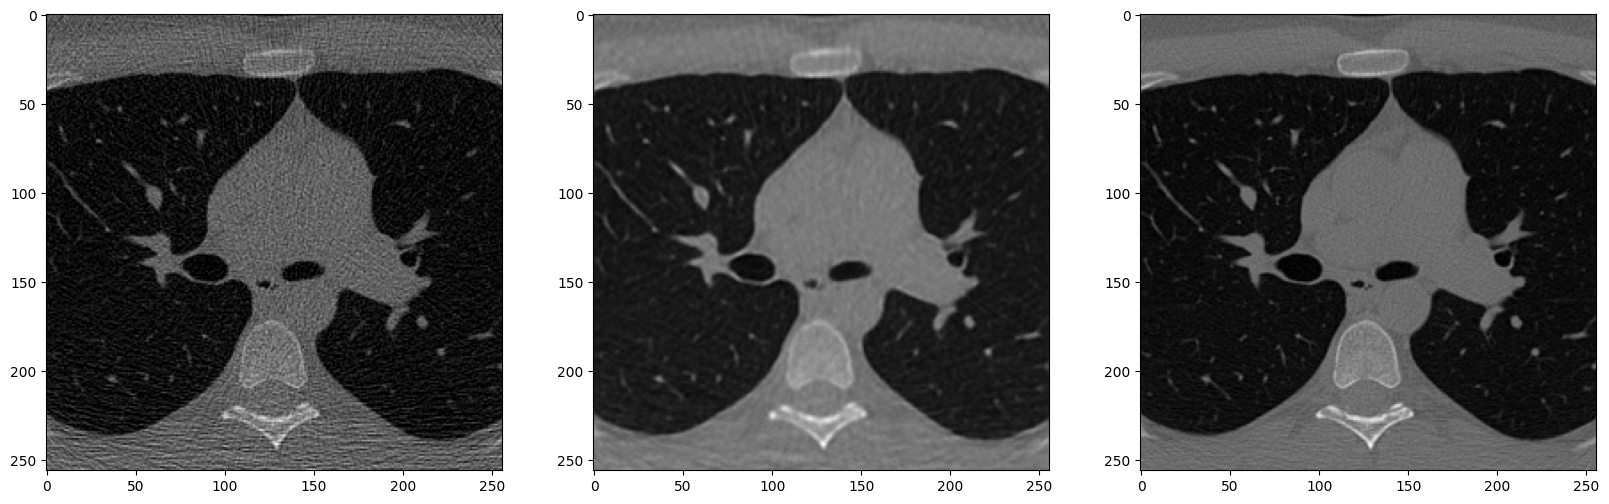

In [ ]:
cropped_img_iter_test = iter(test_data)
val_cropped_img_test  = next(cropped_img_iter_test )
fakes_test  = model.predict(val_cropped_img_test[0])
fig, axes = plt.subplots(1,3, figsize=(20,20))
ds = np.squeeze(val_cropped_img_test[0][0].numpy())
us = np.squeeze(fakes_test[0])
ori = np.squeeze(val_cropped_img_test[1][0])
ds = (ds - ds.min()) / (ds.max() - ds.min())
us = (us - us.min()) / (us.max() - us.min())
ori = (ori - ori.min()) / (ori.max() - ori.min())
axes[0].imshow(ds,cmap='gray')
axes[1].imshow(us,cmap='gray')
axes[2].imshow(ori,cmap='gray')
#plt.savefig('100epoch_wgan_0.0001wei.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


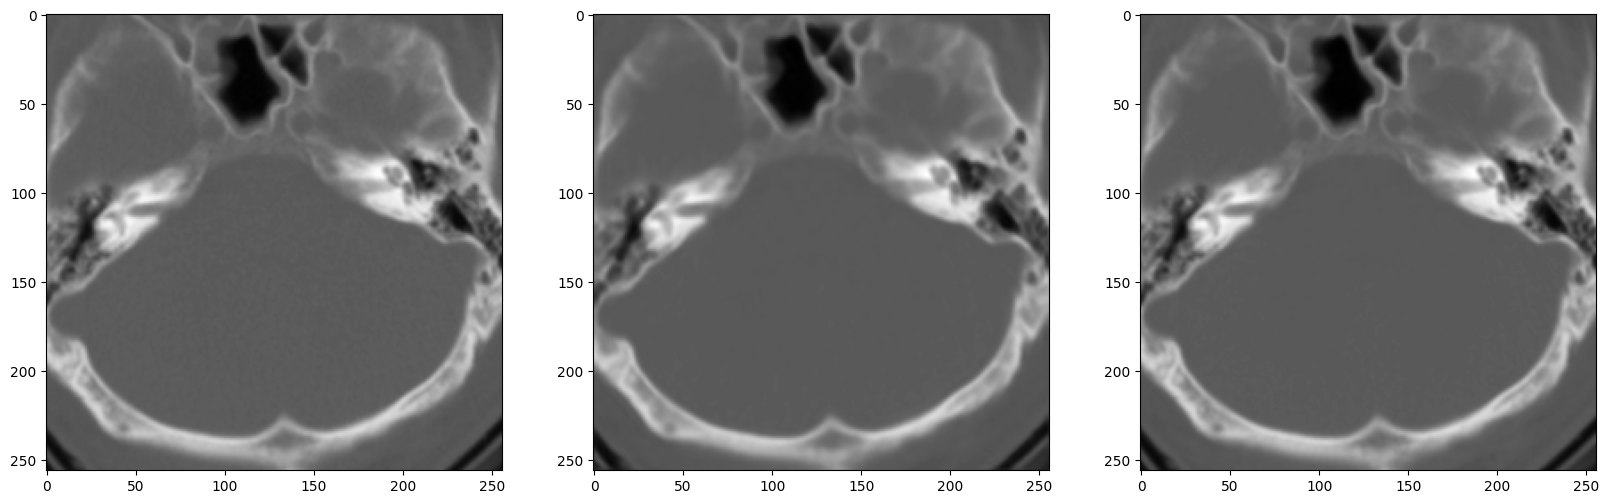

In [ ]:
cropped_img_iter_test = iter(test_data)
val_cropped_img_test  = next(cropped_img_iter_test )
val_cropped_img_test  = next(cropped_img_iter_test )
fakes_test  = model.predict(val_cropped_img_test[0])
fig, axes = plt.subplots(1,3, figsize=(20,20))
ds = np.squeeze(val_cropped_img_test[0][3].numpy())
us = np.squeeze(fakes_test[3])
ori = np.squeeze(val_cropped_img_test[1][3])
ds = (ds - ds.min()) / (ds.max() - ds.min())
us = (us - us.min()) / (us.max() - us.min())
ori = (ori - ori.min()) / (ori.max() - ori.min())
axes[0].imshow(ds,cmap='gray')
axes[1].imshow(us,cmap='gray')
axes[2].imshow(ori,cmap='gray')
#plt.savefig('100epoch_wgan_0.0001wei.png')